### In this nb I improve on the shock variable used in Exploratory1 and compare WTI response with SPX

In [1]:
import pandas as pd

In [2]:
wti = pd.read_csv('data/WTI.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()

<AxesSubplot:xlabel='date'>

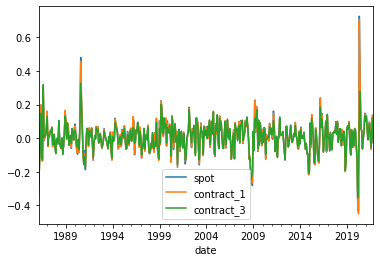

In [3]:
wti_pct = wti.pct_change().dropna()
wti_pct.plot()

In [4]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='date'>

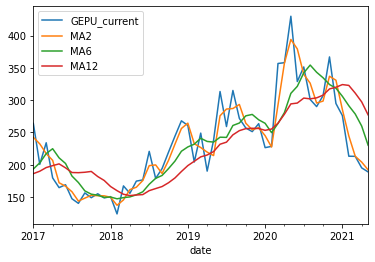

In [5]:
epu = pd.read_csv('data/EPUGlobal.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
epu['MA2'] = epu.GEPU_current.rolling(2).mean()
epu['MA6'] = epu.GEPU_current.rolling(6).mean()
epu['MA12'] = epu.GEPU_current.rolling(12).mean()
epu['MAD2'] = epu.GEPU_current.pct_change() - epu.MA2.pct_change()
epu['MAD6'] = epu.GEPU_current.pct_change() - epu.MA6.pct_change()
epu['MAD12'] = epu.GEPU_current.pct_change() - epu.MA12.pct_change()
epu[['GEPU_current', 'MA2', 'MA6', 'MA12']]['2017-01-01':].plot()

In [6]:
epu.tail()

,GEPU_current,GEPU_ppp,MA2,MA6,MA12,MAD2,MAD6,MAD12
date,,,,,,,,
2021-01-01,276.110681,288.872662,285.485420,306.011544,324.136388,0.073724,-0.024173,-0.076521
2021-02-01,213.135741,222.659348,244.623211,291.356148,322.866002,-0.084946,-0.180187,-0.224159
2021-03-01,212.966679,222.147678,213.051210,278.509712,310.876638,0.128271,0.043299,0.036341
2021-04-01,195.100508,206.676606,204.033594,259.860698,297.298019,-0.041566,-0.016932,-0.040213
2021-05-01,188.815918,198.143322,191.958213,230.164948,277.197867,0.026971,0.082064,0.035397


<AxesSubplot:xlabel='date'>

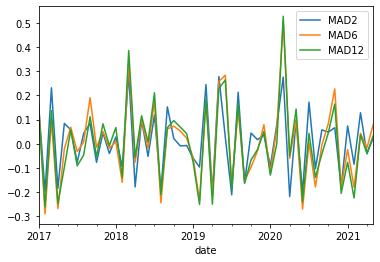

In [7]:
epu[['MAD2', 'MAD6', 'MAD12']].loc['2017-01-01':].plot()

<AxesSubplot:xlabel='date'>

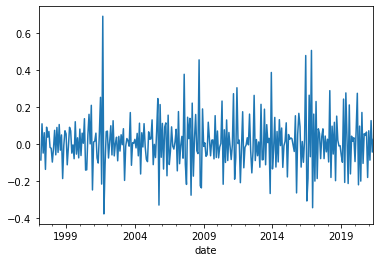

In [8]:
epu.MAD2.plot()

<AxesSubplot:xlabel='date'>

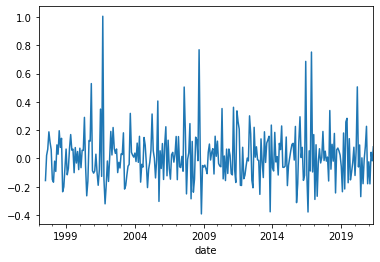

In [9]:
epu.MAD6.plot()

<AxesSubplot:xlabel='date'>

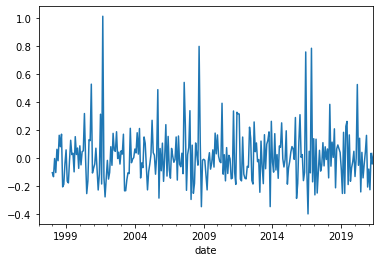

In [10]:
epu.MAD12.plot()

MA12 looks to be the best signal for surprises, but our result should be robust to MAD6 as well.

In [11]:
epu.dropna().head()

,GEPU_current,GEPU_ppp,MA2,MA6,MA12,MAD2,MAD6,MAD12
date,,,,,,,,
1998-01-01,97.823585,94.360973,102.034976,84.966553,78.770782,-0.095510,-0.149922,-0.102426
1998-02-01,85.675712,83.320993,91.749648,88.714002,79.312917,-0.023379,-0.168286,-0.131064
1998-03-01,87.248872,82.809098,86.462292,92.073767,80.877599,0.075990,-0.019510,-0.001366
1998-04-01,78.904417,72.911993,83.076644,91.743772,81.336071,-0.056482,-0.092056,-0.101308
1998-05-01,85.100300,79.190424,82.002359,90.166542,82.464346,0.091455,0.095716,0.064652


In [12]:
df = wti_pct.join(epu[['MAD2', 'MAD6', 'MAD12']]).dropna()
df.head()

,spot,contract_1,contract_3,MAD2,MAD6,MAD12
date,,,,,,
1998-01-01,-0.087834,-0.086790,-0.083957,-0.095510,-0.149922,-0.102426
1998-02-01,-0.039474,-0.038852,-0.030940,-0.023379,-0.168286,-0.131064
1998-03-01,-0.058531,-0.064677,-0.054217,0.075990,-0.019510,-0.001366
1998-04-01,0.015212,0.027926,0.032484,-0.056482,-0.092056,-0.101308
1998-05-01,-0.028664,-0.034282,-0.004935,0.091455,0.095716,0.064652


In [13]:
import statsmodels.api as sm

In [14]:
def news_regression(y_col, x_col, lags=12, df=df):
    x_cols = []
    for i in range(lags+1):
        new_col = f'{x_col}-lag{i}'
        df[new_col] = df[f'{x_col}'].shift(i)
        x_cols.append(new_col)
    df = df.dropna()
    return sm.OLS(df[y_col], sm.add_constant(df[x_cols])).fit()

In [15]:
model1 = news_regression('spot', 'MAD12')
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.375
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.171
Time:                        18:19:24   Log-Likelihood:                 237.21
No. Observations:                 269   AIC:                            -446.4
Df Residuals:                     255   BIC:                            -396.1
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0197      0.006      3.559      0.000       0.009       0.031
MAD12-lag0     -0.0956      0.037     -2.555      0.011      -0.169      -0.022
MAD12-lag1     -0.1206      0.043     -2.832      0.005      -0.204      -0.037
MAD12-lag2     -0.0594      0.057     -1.042      0.299      -0.172       0.053
MAD12-lag3     -0.0311      0.043     -0.729      0.466      -0.115       0.053
MAD12-lag4     -0.0408      0.029     -1.402      0.162      -0.098       0.016
MAD12-lag5     -0.0417      0.030     -1.406      0.161      -0.100       0.017
MAD12-lag6      0.0161      0.034      0.469      0.639      -0.052       0.084
MAD12-lag7     -0.0381      0.029     -1.301      0.195      -0.096       0.020
MAD12-lag8      0.0043      0.031      0.140      0.889      -0.056       0.065
MAD12-lag9     -0.0162      0.038     -0.428      0.669      -0.091       0.058
MAD12-lag10    -0.0365      0.030     -1.210      0.228      -0.096       0.023
MAD12-lag11    -0.0334      0.038     -0.873      0.383      -0.109       0.042
MAD12-lag12    -0.0053      0.036     -0.144      0.886      -0.077       0.067
==============================================================================
Omnibus:                       99.573   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1671.180
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                      15.048   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [16]:
model2 = news_regression('contract_1', 'MAD12')

In [17]:
model3 = news_regression('contract_3', 'MAD12')

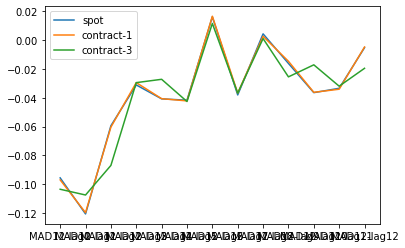

In [18]:
plt.plot(model1.params[1:], label='spot')
plt.plot(model2.params[1:], label='contract-1')
plt.plot(model3.params[1:], label='contract-3')
plt.legend()

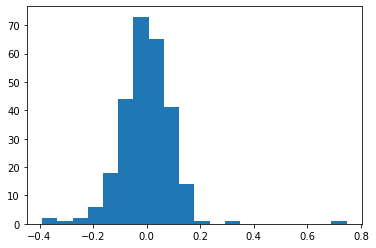

In [19]:
plt.hist(model1.resid, bins=20)
plt.show()

We can see that using MA as benchmark for expectations rather than linearly exptraolating last month's data (as in Exploratory1) is a more unbiased estimator of shock value. However, fat tails remain due to increased variance in shocks in recent years.

<AxesSubplot:xlabel='date'>

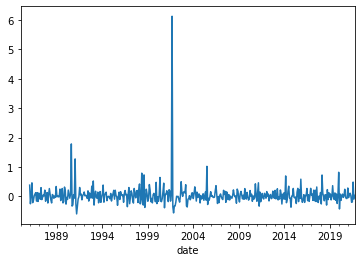

In [20]:
gpr = pd.read_csv('data/GPRGlobal.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
gpr['MA12'] = gpr.GPRI.rolling(12).mean()
gpr['MAD12'] = gpr.GPRI.pct_change() - gpr.MA12.pct_change()
gpr['MAD12'].plot()

In [21]:
df2 = wti_pct.join(gpr['MAD12'])

In [22]:
model4 = news_regression('spot', 'MAD12', df=df2)
model4.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.9467
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.504
Time:                        18:19:25   Log-Likelihood:                 393.73
No. Observations:                 418   AIC:                            -759.5
Df Residuals:                     404   BIC:                            -703.0
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0091      0.005      1.854      0.064      -0.001       0.019
MAD12-lag0      0.0043      0.018      0.237      0.813      -0.031       0.040
MAD12-lag1     -0.0107      0.016     -0.685      0.494      -0.041       0.020
MAD12-lag2     -0.0206      0.009     -2.214      0.027      -0.039      -0.002
MAD12-lag3     -0.0220      0.015     -1.469      0.142      -0.051       0.007
MAD12-lag4      0.0036      0.013      0.275      0.784      -0.022       0.029
MAD12-lag5      0.0017      0.008      0.218      0.828      -0.014       0.017
MAD12-lag6      0.0012      0.019      0.060      0.952      -0.037       0.039
MAD12-lag7     -0.0095      0.014     -0.683      0.495      -0.037       0.018
MAD12-lag8      0.0016      0.008      0.210      0.834      -0.013       0.017
MAD12-lag9      0.0069      0.014      0.491      0.624      -0.021       0.035
MAD12-lag10    -0.0032      0.011     -0.298      0.766      -0.024       0.018
MAD12-lag11     0.0102      0.008      1.310      0.191      -0.005       0.026
MAD12-lag12     0.0022      0.007      0.308      0.758      -0.012       0.017
==============================================================================
Omnibus:                      117.114   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1758.228
Skew:                           0.740   Prob(JB):                         0.00
Kurtosis:                      12.938   Cond. No.                         4.14
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
model5 = news_regression('contract_1', 'MAD12', df=df2)
model6 = news_regression('contract_3', 'MAD12', df=df2)

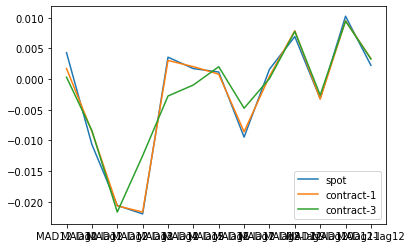

In [24]:
plt.plot(model4.params[1:], label='spot')
plt.plot(model5.params[1:], label='contract-1')
plt.plot(model6.params[1:], label='contract-3')
plt.legend()

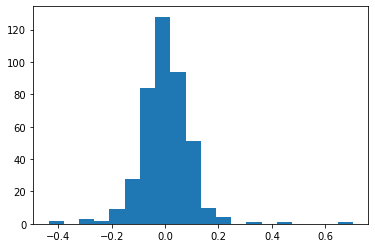

In [25]:
plt.hist(model4.resid, bins=20)
plt.show()

To account for US interventions in the Middle East at the turn of the millenium, we can split the data into pre-2005 and post-2005 to see if that changes our GPRI regression.

In [26]:
model7 = news_regression('spot', 'MAD12', df=df2.loc[:'2005-01-01'])
model7.get_robustcov_results().summary()

<ipython-input-14-db4d7de90bb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[f'{x_col}'].shift(i)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                     1.231
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.259
Time:                        18:19:25   Log-Likelihood:                 243.94
No. Observations:                 216   AIC:                            -459.9
Df Residuals:                     202   BIC:                            -412.6
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0081      0.006      1.468      0.144      -0.003       0.019
MAD12-lag0      0.0075      0.021      0.351      0.726      -0.035       0.050
MAD12-lag1     -0.0105      0.016     -0.641      0.522      -0.043       0.022
MAD12-lag2     -0.0182      0.006     -2.874      0.004      -0.031      -0.006
MAD12-lag3     -0.0094      0.007     -1.328      0.186      -0.023       0.005
MAD12-lag4     -0.0041      0.008     -0.503      0.615      -0.020       0.012
MAD12-lag5      0.0015      0.006      0.241      0.810      -0.011       0.014
MAD12-lag6      0.0037      0.020      0.183      0.855      -0.036       0.043
MAD12-lag7     -0.0063      0.013     -0.481      0.631      -0.032       0.020
MAD12-lag8      0.0103      0.008      1.292      0.198      -0.005       0.026
MAD12-lag9      0.0023      0.011      0.207      0.836      -0.020       0.024
MAD12-lag10     0.0026      0.008      0.333      0.740      -0.013       0.018
MAD12-lag11     0.0055      0.007      0.818      0.414      -0.008       0.019
MAD12-lag12    -0.0017      0.008     -0.222      0.824      -0.017       0.013
==============================================================================
Omnibus:                       57.781   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.725
Skew:                           0.996   Prob(JB):                     1.07e-51
Kurtosis:                       7.703   Cond. No.                         3.14
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [27]:
model8 = news_regression('spot', 'MAD12', df=df2.loc['2005-01-01':])
model8.get_robustcov_results().summary()

<ipython-input-14-db4d7de90bb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = df[f'{x_col}'].shift(i)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.256
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.244
Time:                        18:19:25   Log-Likelihood:                 156.94
No. Observations:                 191   AIC:                            -285.9
Df Residuals:                     177   BIC:                            -240.3
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0207      0.011      1.865      0.064      -0.001       0.043
MAD12-lag0     -0.0566      0.042     -1.357      0.176      -0.139       0.026
MAD12-lag1     -0.0702      0.051     -1.383      0.168      -0.170       0.030
MAD12-lag2     -0.1128      0.072     -1.574      0.117      -0.254       0.029
MAD12-lag3     -0.1550      0.075     -2.063      0.041      -0.303      -0.007
MAD12-lag4      0.0168      0.095      0.178      0.859      -0.170       0.203
MAD12-lag5     -0.0306      0.067     -0.456      0.649      -0.163       0.102
MAD12-lag6     -0.0634      0.060     -1.061      0.290      -0.181       0.054
MAD12-lag7     -0.0796      0.048     -1.644      0.102      -0.175       0.016
MAD12-lag8     -0.0876      0.056     -1.565      0.119      -0.198       0.023
MAD12-lag9     -0.0140      0.065     -0.214      0.831      -0.143       0.115
MAD12-lag10    -0.0523      0.060     -0.870      0.386      -0.171       0.066
MAD12-lag11     0.0065      0.054      0.121      0.904      -0.100       0.113
MAD12-lag12     0.0163      0.050      0.324      0.746      -0.083       0.116
==============================================================================
Omnibus:                       35.273   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              309.088
Skew:                           0.205   Prob(JB):                     7.63e-68
Kurtosis:                       9.218   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

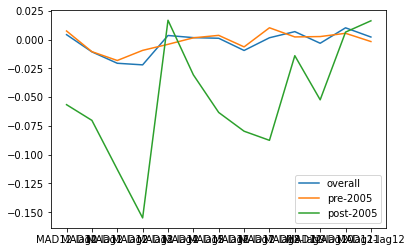

In [28]:
plt.plot(model4.params[1:], label='overall')
plt.plot(model7.params[1:], label='pre-2005')
plt.plot(model8.params[1:], label='post-2005')
plt.legend()

How does crude's reaction time compare to stocks? We will test this with EPU shocks.

In [29]:
spx = pd.read_csv('data/SP500.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
df3 = spx.pct_change().join(epu['MAD12']).dropna()
df3.head()

,SP500,MAD12
date,,
2012-02-01,0.040589,-0.146509
2012-03-01,0.031332,-0.056971
2012-04-01,-0.007497,-0.063682
2012-05-01,-0.062651,0.222572
2012-06-01,0.039555,0.143219


In [30]:
model9 = news_regression('SP500', 'MAD12', df=df3)
model9.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.549
Date:                Fri, 31 Dec 2021   Prob (F-statistic):              0.116
Time:                        18:19:25   Log-Likelihood:                 194.14
No. Observations:                 100   AIC:                            -360.3
Df Residuals:                      86   BIC:                            -323.8
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0111      0.005      2.331      0.022       0.002       0.021
MAD12-lag0     -0.0340      0.026     -1.295      0.199      -0.086       0.018
MAD12-lag1      0.0489      0.023      2.175      0.032       0.004       0.094
MAD12-lag2      0.0148      0.021      0.709      0.480      -0.027       0.056
MAD12-lag3     -0.0057      0.019     -0.300      0.765      -0.044       0.032
MAD12-lag4      0.0156      0.022      0.697      0.488      -0.029       0.060
MAD12-lag5      0.0009      0.026      0.033      0.973      -0.051       0.052
MAD12-lag6     -0.0124      0.025     -0.499      0.619      -0.062       0.037
MAD12-lag7     -0.0458      0.025     -1.853      0.067      -0.095       0.003
MAD12-lag8      0.0088      0.027      0.320      0.750      -0.046       0.063
MAD12-lag9     -0.0259      0.027     -0.952      0.344      -0.080       0.028
MAD12-lag10    -0.0028      0.025     -0.112      0.911      -0.052       0.046
MAD12-lag11     0.0217      0.020      1.095      0.277      -0.018       0.061
MAD12-lag12     0.0220      0.019      1.136      0.259      -0.016       0.060
==============================================================================
Omnibus:                        4.063   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.614
Skew:                          -0.308   Prob(JB):                        0.164
Kurtosis:                       3.699   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

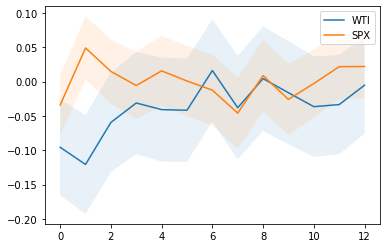

In [31]:
plt.plot(model1.params[1:].reset_index(drop=True), label='WTI')
plt.plot(model9.params[1:].reset_index(drop=True), label='SPX')
plt.fill_between([*range(13)], model1.conf_int()[0][1:], model1.conf_int()[1][1:], alpha=.1)
plt.fill_between([*range(13)], model9.conf_int()[0][1:], model9.conf_int()[1][1:], alpha=.1)
plt.legend()

How about if we now look at shocks in the VIX?

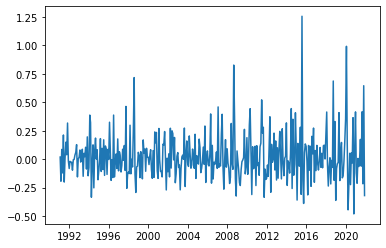

In [32]:
vix = pd.read_csv('data/VIX.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
vix['MA12'] = vix.VIX.rolling(12).mean()
vix['MAD12'] = vix.VIX.pct_change() - vix.MA12.pct_change()
plt.plot(vix.MAD12)

In [33]:
df4 = spx.pct_change().join(vix['MAD12']).dropna()
df4.head()

,SP500,MAD12
date,,
2012-02-01,0.040589,-0.052237
2012-03-01,0.031332,-0.151074
2012-04-01,-0.007497,0.097913
2012-05-01,-0.062651,0.372543
2012-06-01,0.039555,-0.292025


In [34]:
model10 = news_regression('SP500', 'MAD12', df=df4)
model10.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     6.234
Date:                Fri, 31 Dec 2021   Prob (F-statistic):           2.82e-08
Time:                        18:19:26   Log-Likelihood:                 245.80
No. Observations:                 107   AIC:                            -463.6
Df Residuals:                      93   BIC:                            -426.2
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0211      0.003      6.605      0.000       0.015       0.027
MAD12-lag0     -0.1163      0.015     -7.618      0.000      -0.147      -0.086
MAD12-lag1     -0.0481      0.017     -2.764      0.007      -0.083      -0.014
MAD12-lag2     -0.0077      0.021     -0.366      0.715      -0.049       0.034
MAD12-lag3     -0.0127      0.013     -0.974      0.332      -0.039       0.013
MAD12-lag4     -0.0182      0.011     -1.584      0.116      -0.041       0.005
MAD12-lag5     -0.0154      0.015     -1.058      0.293      -0.044       0.013
MAD12-lag6     -0.0085      0.016     -0.541      0.590      -0.040       0.023
MAD12-lag7     -0.0252      0.016     -1.534      0.128      -0.058       0.007
MAD12-lag8     -0.0163      0.014     -1.192      0.236      -0.043       0.011
MAD12-lag9     -0.0049      0.013     -0.390      0.697      -0.030       0.020
MAD12-lag10    -0.0171      0.010     -1.641      0.104      -0.038       0.004
MAD12-lag11    -0.0036      0.011     -0.324      0.746      -0.025       0.018
MAD12-lag12    -0.0042      0.009     -0.475      0.636      -0.022       0.013
==============================================================================
Omnibus:                        5.416   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                7.598
Skew:                           0.130   Prob(JB):                       0.0224
Kurtosis:                       4.279   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [35]:
df5 = wti_pct.join(vix['MAD12']).dropna()
model11 = news_regression('spot', 'MAD12', df=df5)
model11.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spot   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1.944
Date:                Fri, 31 Dec 2021   Prob (F-statistic):             0.0247
Time:                        18:19:26   Log-Likelihood:                 357.64
No. Observations:                 358   AIC:                            -687.3
Df Residuals:                     344   BIC:                            -632.9
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0129      0.005      2.443      0.015       0.003       0.023
MAD12-lag0     -0.0644      0.024     -2.713      0.007      -0.111      -0.018
MAD12-lag1     -0.1386      0.040     -3.461      0.001      -0.217      -0.060
MAD12-lag2     -0.0827      0.045     -1.821      0.070      -0.172       0.007
MAD12-lag3     -0.0270      0.067     -0.404      0.686      -0.158       0.104
MAD12-lag4      0.0090      0.048      0.189      0.850      -0.085       0.103
MAD12-lag5      0.0154      0.038      0.401      0.688      -0.060       0.091
MAD12-lag6      0.0150      0.031      0.480      0.632      -0.047       0.077
MAD12-lag7      0.0106      0.032      0.332      0.740      -0.052       0.073
MAD12-lag8     -0.0059      0.026     -0.222      0.825      -0.058       0.046
MAD12-lag9      0.0241      0.032      0.764      0.445      -0.038       0.086
MAD12-lag10     0.0039      0.027      0.145      0.885      -0.049       0.057
MAD12-lag11    -0.0114      0.027     -0.423      0.673      -0.065       0.042
MAD12-lag12     0.0265      0.034      0.773      0.440      -0.041       0.094
==============================================================================
Omnibus:                       97.111   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1010.632
Skew:                           0.796   Prob(JB):                    3.50e-220
Kurtosis:                      11.076   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

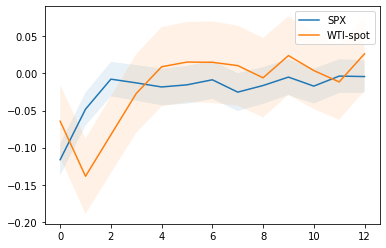

In [36]:
plt.plot(model10.params[1:].reset_index(drop=True), label='SPX')
plt.plot(model11.params[1:].reset_index(drop=True), label='WTI-spot')
plt.fill_between([*range(13)], model10.conf_int()[0][1:], model10.conf_int()[1][1:], alpha=.1)
plt.fill_between([*range(13)], model11.conf_int()[0][1:], model11.conf_int()[1][1:], alpha=.1)
plt.legend()

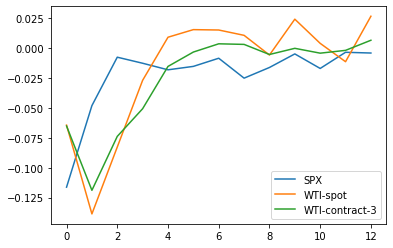

In [37]:
model12 = news_regression('contract_3', 'MAD12', df=df5)
plt.plot(model10.params[1:].reset_index(drop=True), label='SPX')
plt.plot(model11.params[1:].reset_index(drop=True), label='WTI-spot')
plt.plot(model12.params[1:].reset_index(drop=True), label='WTI-contract-3')
plt.legend()

Not surprising that WTI reacts slower than stocks to changes in the VIX.